# Assignment1. MNIST Digit Recogntion

이 과제에서는 손으로 쓴 숫자들의 이미지를 input으로 받아서 0~9 중 어느 숫자에 해당하는지를 분류하는 10-way Classification Problem을 풀어 볼 겁니다. 지금까지 실습은 가상의 인공 데이터셋이었다면 이번에는 real-world 데이터셋이니 좀 더 설레지 않나요?

`pytorch` 내에 이미 구현되어 있는 MNIST Dataset을 사용하여 데이터가 공급됩니다.  
대신 여러분들은 Model을 짜고 올바르게 Loss Function을 활용하는 코드를 작성하는데 집중해주시길 바랍니다.  

1. 현재 Linear Model만 구현이 되어 있습니다. MLP Model을 2.Model Architecture 부분에 구현해주세요.
2. MLP Model을 생성할 때 hidden unit 수와 hidden layer 수를 인풋으로 넣어주면 해당 값으로 MLP가 자동으로 생성되게 하는 코드를 구현해보세요.  
3. 다양한 hidden_unit과 hidden_layer 그리고 learning rate를 바꿔가면서 정확도의 변화를 알려주세요(이 때 모델이 고정되었다면 learning rate부터 바꿔가면서 튜닝해보세요. 차트나 표를 자유롭게 활용하여 결과를 보여주세요.  
4. 실험했던 결과 중 Test Set에 대한 Accuracy가 가장 높았던 실험 조건과 그때의 Accuracy를 알려주세요!  
5. 양식은 따로 없으며 이 주피터 노트북의 뒷부분에 추가로 1~4의 내용을 덧붙여서 정리하면 되겠습니다!   

*Written by. 조재영(whwodud9@kaist.ac.kr) 2019.01.21 *

### Install Pytorch 1.0 (For Google Colab)

In [ ]:
"""#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
"""

### 1. Data Preparation

**Data Set**  
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!



50000 10000 10000


### Inspecting Dataset

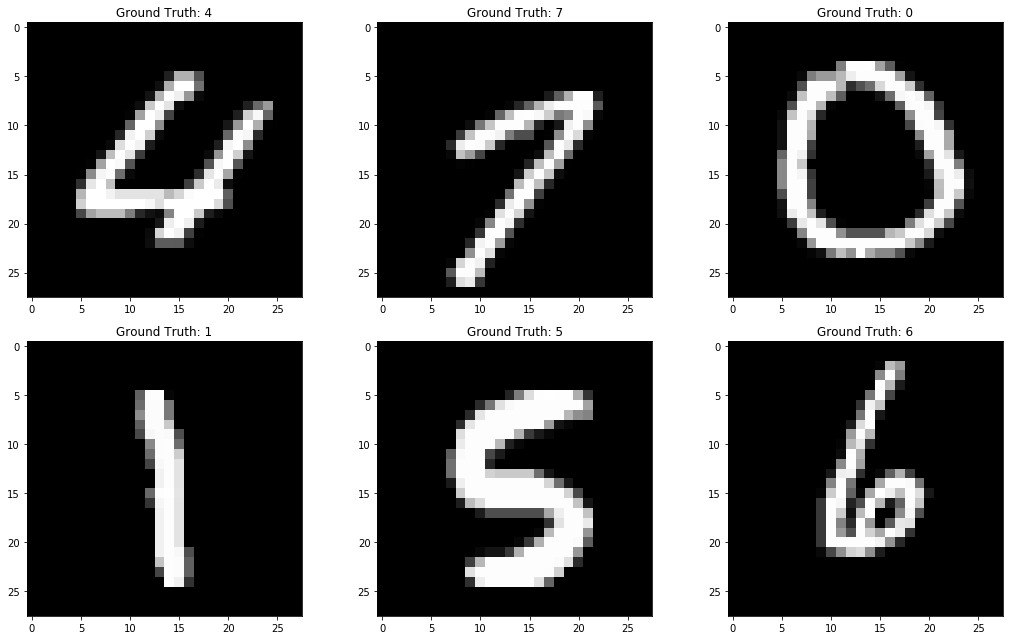

In [2]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

### 2. Model Architecture

In [3]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

In [4]:
cls_loss = nn.CrossEntropyLoss()

### 4. Train & Evaluation

In [7]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel()
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    optimizer.zero_grad() 
    
    for input_X, true_y in train_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    optimizer.zero_grad()
    
    for input_X, true_y in val_loader:
        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        val_loss += loss.detach().numpy()
    val_loss = val_loss / len(val_loader)
    list_val_loss.append(val_loss)
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))

Number of 7850 parameters
Epoch: 0, Train Loss: 1.507788436110977, Val Loss: 1.9929688346536854


KeyboardInterrupt: 

### 5. Test

In [8]:
# ====== Evaluation ======= #
correct = 0
model.eval()
optimizer.zero_grad()

for input_X, true_y in test_loader:
    input_X = input_X.squeeze()
    input_X = input_X.view(-1, 784)
    pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
    correct += pred_y.eq(true_y).sum()

acc = correct.numpy() / len(test_loader.dataset)
list_acc.append(acc)
list_acc_epoch.append(i)

print('Test Acc: {}%'.format(acc*100))

Test Acc: 90.44%


### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려봅시다.   
Loss가 꾸준히 줄어드는지 확인하고 val_loss가 증가하기 시킨다면 그 이상의 학습은 점점 모델의 성능을 망침을 뜻합니다. 
그 옆에는 Epoch에 따라서 MAE metric이 얼마나 감소하는지 확인해봅시다.

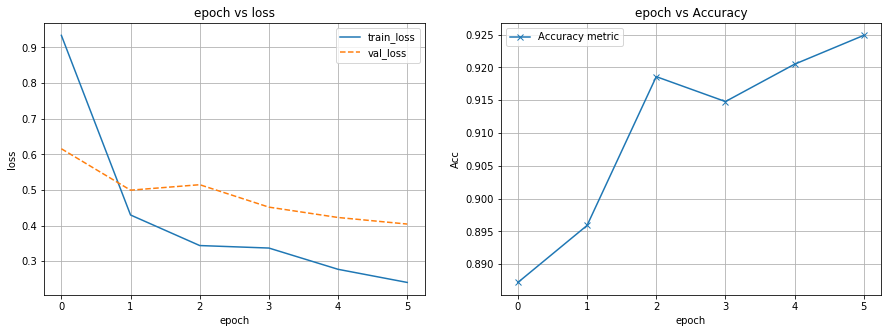

In [85]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()